In [229]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

In [230]:
max_sequence_length = 100
max_vocab_size = 3000
embedding_dim = 50
validation_split = 0.2
batch_size = 128
epochs = 10
# latent_dim = 20

In [231]:
def get_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.strip().split()
            word2vec[values[0]] = np.array(values[1:], dtype=np.float32)
    return word2vec

In [232]:
def get_data(file_name):
    input_texts = []
    target_texts = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.rstrip()
            if not line:
                continue
            
            # Note here
            input_line = '<sos> ' + line
            target_line = line + ' <eos>'
            
            input_texts.append(input_line)
            target_texts.append(target_line)
    
    return input_texts, target_texts

In [233]:
word2vec_file_path = 'data/glove.6B.50d.txt'
data_file_path = 'data/robert_frost.txt'

In [234]:
input_texts, target_texts = get_data(data_file_path)

In [235]:
print('# of words: ', len(word2vec))
print('# of input_texts: ', len(input_texts))
print('# of target_texts: ', len(target_texts))

# of words:  400000
# of input_texts:  1436
# of target_texts:  1436


In [236]:
all_lines = input_texts + target_texts

In [237]:
# convert sentences in form of words into sequences in form of integers 

# Note filters parameter: the filters will filter out special characters
# out <sos> and <eos> both contain special characters which are '<' and '>'
tokenizer = Tokenizer(num_words=max_vocab_size, filters='')
tokenizer.fit_on_texts(all_lines)

In [238]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)
# print('input sequences shape:', input_sequences.shape)
# print('target sequences shape:', target_sequences.shape)

In [239]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('max sequence length:', max_sequence_length_from_data)

max sequence length: 12


In [240]:
word2index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word2index)))
assert('<sos>' in word2index)
assert('<eos>' in word2index)

Found 3056 unique tokens.


In [114]:
max_sequence_length = min(max_sequence_length, max_sequence_length_from_data)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('input sequences shape:', input_sequences.shape)
print('target sequences shape:', target_sequences.shape)

input sequences shape: (1436, 12)
target sequences shape: (1436, 12)


In [115]:
# one-hot the targets (cannot use sparse cross-entropy)
num_words = min(max_vocab_size + 1, len(word2index) + 1)

one_hot_targets = np.zeros((len(target_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        one_hot_targets[i, t, word] = 1

In [116]:
print(one_hot_targets.shape)
print(one_hot_targets[0,0])
print(one_hot_targets[0,1])

(1436, 12, 3001)
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]


## Model

In [117]:
max_sequence_length

12

In [118]:
word2vec = get_word2vec(word2vec_file_path)

In [207]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, index in word2index.items():
    if index <= max_vocab_size:
        vec = word2vec.get(word)
        if vec is not None:
            embedding_matrix[index] = vec

# Note: do not set the input_length parameter since the embedding_layer will be used 
# in both encode and decode where take different input length
embedding_layer = Embedding(
                           embedding_matrix.shape[0],
                           embedding_matrix.shape[1],
                           weights=[embedding_matrix],
#                            input_length=max_sequence_length,
#                            trainable=False
                           )

In [223]:
latent_dim = 20

initial_h = Input(shape=(latent_dim,))
initial_c = Input(shape=(latent_dim,))
input_ = Input(shape=(max_sequence_length,))
x = embedding_layer(input_)
lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])

# how about TimeDistributedDense
# dense = Dense(num_words, activation='softmax')
dense = TimeDistributed(Dense(num_words, activation='softmax'))
output = dense(x)

model = Model(inputs=[input_, initial_h, initial_c], outputs=output)

In [224]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_81 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          multiple              150050      input_81[0][0]                   
____________________________________________________________________________________________________
input_79 (InputLayer)            (None, 20)            0                                            
____________________________________________________________________________________________________
input_80 (InputLayer)            (None, 20)            0                                            
___________________________________________________________________________________________

In [225]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [226]:
z = np.zeros((len(input_sequences), latent_dim))
r = model.fit([input_sequences, z, z], one_hot_targets, batch_size=batch_size, epochs=30, 
          validation_split=validation_split)

Train on 1148 samples, validate on 288 samples
Epoch 1/30
1148/1148 [==============================] - 10s - loss: 7.6230 - acc: 0.2109 - val_loss: 6.8420 - val_acc: 0.2951
Epoch 2/30
1148/1148 [==============================] - 7s - loss: 6.0252 - acc: 0.3010 - val_loss: 5.6073 - val_acc: 0.2894
Epoch 3/30
1148/1148 [==============================] - 7s - loss: 5.0565 - acc: 0.2983 - val_loss: 5.2905 - val_acc: 0.2894
Epoch 4/30
1148/1148 [==============================] - 7s - loss: 4.8774 - acc: 0.2983 - val_loss: 5.2365 - val_acc: 0.2894
Epoch 5/30
1148/1148 [==============================] - 7s - loss: 4.7333 - acc: 0.2983 - val_loss: 5.2059 - val_acc: 0.2894
Epoch 6/30
1148/1148 [==============================] - 7s - loss: 4.6432 - acc: 0.2983 - val_loss: 5.2570 - val_acc: 0.2894
Epoch 7/30
1148/1148 [==============================] - 7s - loss: 4.5603 - acc: 0.2983 - val_loss: 5.1287 - val_acc: 0.2894
Epoch 8/30
1148/1148 [==============================] - 7s - loss: 4.4750 - a

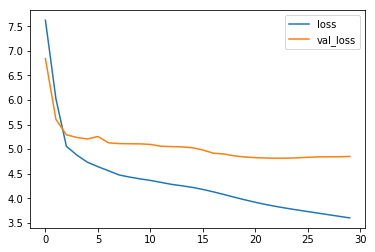

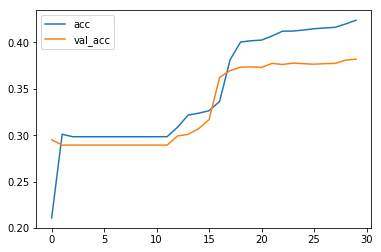

In [227]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

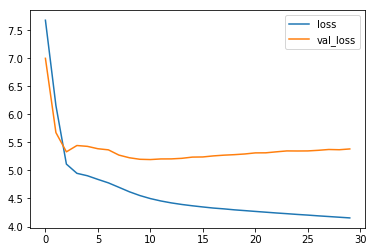

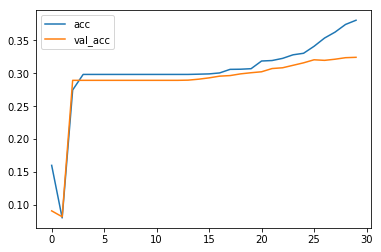

In [212]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## Sampling

In [213]:
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


sampling_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_78 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          multiple              150050      input_78[0][0]                   
____________________________________________________________________________________________________
input_75 (InputLayer)            (None, 20)            0                                            
____________________________________________________________________________________________________
input_76 (InputLayer)            (None, 20)            0                                            
___________________________________________________________________________________________

In [214]:
index2word = {v:k for k, v in word2index.items()}

In [221]:
def sample_line():
    
    np_input = np.array([[word2index['<sos>']]])
    
    
    h = np.zeros((1, latent_dim))
    c = np.zeros((1, latent_dim))
    
#     print(np_input.shape)
#     print(h.shape)
#     print(c.shape)
    
    eos = word2index['<eos>']

    output_sentence = []
    
    for _ in range(max_sequence_length):
        
        o, h, c = sampling_model.predict([np_input, h, c])
#         print(o.shape)
        probs = o[0,0]
        
        # sampling
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break
        
        output_sentence.append(index2word.get(idx, '<WTF %s>' % idx))
        
        np_input[0,0] = idx
    
    return ' '.join(output_sentence)
        

In [222]:
while True:
    for _ in range(4):
        print(sample_line())

bed. makes i'm our doubt years
whir confusion <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> himself <WTF 0> <WTF 0>
everything said don't descent
sprung, two the wire but whom stairs. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
'strangely, there think
a night then one mad.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
decently <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
bed, when when his leaves, <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> besides
technical.- out
there to yourself; <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
died. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
never boston bed the three <WTF 0> under <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
coming heel.
for looked the himself, <WTF 0>
eyes, a bed.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> nodded. <WTF 0>
please see as afar
destruction destination the <WTF 0> <WTF 0> <WTF 0>

meeting out.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> ' <WTF 0> <WTF 0> <WTF 0>
dark not was rain out.)
things- <WTF 0>
prove playhouse desire
earth did 2o3 the
if the cedar rear <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
old he's saw to the they three. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
crutch, to when that the <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
they to the of trouble's <WTF 0> <WTF 0> make <WTF 0> <WTF 0> <WTF 0> <WTF 0>
'and due how we 'for speed,- only see
queer what son <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> mica again—
blew they got here out-doors. she's going
empty. cold
slight, pair in ice
yourself we business paddle mist
old find was her sill- stopping but
afar stood <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
of hidden done the see had was like
came as what where pride wizard
left's thrown
where think the and he the a gnaws from of. <WTF 0> <WTF 0>
rain was i know young. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0

mebbe only on hair against he behind dignity stopping up <WTF 0> <WTF 0>
iron am.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> in <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
i'll to do the and a each struck away.
charge aster they've bring time, but send <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
come stone by both of one this many the haunt stood as
door can been to the <WTF 0> hair <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
trillium light <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
angelic heaven
help it, arms <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
march young. it again of to
through arthur nights it the sat poetess's clock to to
though bones that as a tell and whom <WTF 0> <WTF 0>
that
should paused at a
your that to the song, have cellar <WTF 0> <WTF 0> field, cellar. <WTF 0>
i over, ask
swish miles flowers the salt in
his 'you where small rain. the would
them, stained me mark in and on all <WTF 0> <WTF 0>
took he'd wanted me i far enough our so broken, off?
was a of among was were lap sunny they t

battle more <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
double-locked singing <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
sunday <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
there'd window, voices of
me
at the a smell <WTF 0> came before <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
got i, purport <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
door: half all the to a neither <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
describing traveled done do help
instead a mile, <WTF 0> <WTF 0> <WTF 0> <WTF 0>
i i'll your road out the made done faded <WTF 0> books. <WTF 0>
her thought much the <WTF 0> unless <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
with from where know fire, yawning stairs daylight.'
instep help to
a
made the to begin
sighed,
place.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
i blue, far
mormon song me 

where they hate clear <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
they'd felt hour had of <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
wrote where of was more cottages that of brown,
sees
' him it as in and or way finger-bone the i
stop in for youthful must the short family place

sat 'in hillside the
to is door-sill chisel tower voices.'
care
shaded favor voted <WTF 0>
a
didn't you rain they one sometime you dragged
been cold stained out past or if me <WTF 0>
made has up you're <WTF 0>
particular and <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
angelic vines- toffile
trodden brown, witch?
a and there.
clock
driven
of has guide swollen matter tree at feel davis stay for <WTF 0>
was don't i passed broken me find to too <WTF 0>
arm, overflowing he
case very round
then, from battle
to the having a were show priority <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
to in the queer
keep, gold brittle tourist.
she care- throw glass
like seems them one

perish seated, got <WTF 0> <WTF 0> cheek, <WTF 0> <WTF 0> <WTF 0> <WTF 0> remember <WTF 0>
his of and the resurrected laughed
lap. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
husband <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> attic <WTF 0> <WTF 0> <WTF 0>
see
has among yourself; <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
two
see? stop. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
myself is ground didn't any you <WTF 0> revolving <WTF 0> <WTF 0> <WTF 0> <WTF 0>
with acquainted of too of the
another married emptied
stained
track. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
bones there the off.' a <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
up chandelier. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
magic shouted, match
seem night,
weakly what blue,
an an <WTF 0>
the chimney were


they <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
of take
help; times; enough: <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
you blue; <WTF 0>
night quite but and as looked the had chanced, every <WTF 0> <WTF 0>
dim piled be
am piercing afar
i to away. must given
a town out oracle.' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
where this furthest lost remoteness going <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
s'pose, chill door, <WTF 0> crooked god's thorn.)
end ought an might
dig cane the side <WTF 0>
ice. south
to.
bones meet came expecting
it,
plowed mica misted.
better
they of folks in tell as heard there that as to stood
playthings night to <WTF 0>
tempt going looking in <WTF 0>
county. what ascending he's grown they <WTF 0>
amy's <WTF 0> talking. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
graciously.
room, over-heated, <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> we <WTF 0> <WTF 0>
winds grave.' there, 

idled really at the
you <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
it bones- her brought courage you
was snow
don't but you're for to they much wasps
living, floor off ground. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
everything got said,
sounds
call feet. though to it.' <WTF 0> <WTF 0> <WTF 0>
cellar-stairs down
a he does genealogy yet
that and silver would
i you the the sap <WTF 0>
to of someone by-road stint <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
about everything still fifteen sailed. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
his her from making and they hours the out know must that
i the lurched, from had i but to a it's he
tell something marshall, the not wasps at now shoulders, may, <WTF 0> <WTF 0>
substitute. rain in until
of gone. to
doesn't full hue had in a sailed. youthful
though, <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
tell with
into had 

old man or name a longer rain that something. <WTF 0> <WTF 0> <WTF 0>
stand in
been they up our town me?' <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
it's grown end fell and coming teased. !' you
saved all anything green with but <WTF 0> earth all <WTF 0> <WTF 0> <WTF 0>
i'll lay it take
'quick had i leave
salted.
descended say!-
proof.' reconnoitre, <WTF 0> <WTF 0>
sake!' (and
alias
consult back no ought mountain often himself,
when no time had fond voices.
stricken describing there,' toppling bearings, say <WTF 0> <WTF 0>
they had longer. first's
by dust her as hurt and was speak it we we're where
him a and the lying what had save the gnaw she redoubling
all shoeing match thinks fortune. <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>
of brushed shelf's but with from i they that see i'd at
i'm on off and transfixed were myself
have a in of would to the southeast-northwest, <WTF 0> <WTF 0> <WTF 0> <WTF 0>
this ' spot. <WTF 0> <WTF 0>
home to when has
never night good reall

took your mean been see? voices. <WTF 0> <WTF 0> <WTF 0> <WTF 0> own <WTF 0>
some was
forty
tourist. <WTF 0> <WTF 0>
door: consent the it, <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0> <WTF 0>


KeyboardInterrupt: 

In [181]:

def sample_line():
  # initial inputs
    np_input = np.array([[ word2index['<sos>'] ]])
    h = np.zeros((1, latent_dim))
    c = np.zeros((1, latent_dim))

    # so we know when to quit
    eos = word2index['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])

        # print("o.shape:", o.shape, o[0,0,:10])
        # idx = np.argmax(o[0,0])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

    # accuulate output
    output_sentence.append(index2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

    return ' '.join(output_sentence)